# 資料處理

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
filepath = '/content/gdrive/MyDrive/VRDL_HW3'

if os.path.isdir(filepath):
  print(filepath+' exists')
else:
  print(filepath+' does not exist.')
  os.makedirs(filepath)

/content/gdrive/MyDrive/VRDL_HW3 exists


In [ ]:
import os
filepath = '/content/gdrive/MyDrive/VRDL_HW3/dataset'

if os.path.isdir(filepath):
  print(filepath+' exists')
else:
  print(filepath+' does not exist.')
  os.makedirs(filepath)

  #下載作業提供的data
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1bU7pdDGdIIYi-PxL7bP5yYQYgyuNJyp7',
                                      dest_path='/content/gdrive/MyDrive/VRDL_HW3/dataset.zip',
                                      unzip=False)
  !unzip /content/gdrive/MyDrive/VRDL_HW3/dataset.zip -d /content/gdrive/MyDrive/VRDL_HW3

/content/gdrive/MyDrive/VRDL_HW3/dataset exists


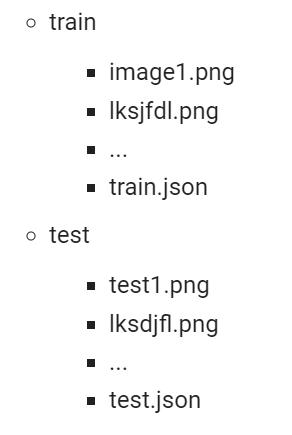

In [ ]:
all_img = []
for x in os.listdir(r'/content/gdrive/MyDrive/VRDL_HW3/dataset/train'):
  all_img.append(x)

# 總共24張圖,畫分成20:4 train跟validation data
train_img = all_img[:20]
val_img = all_img[20:]

In [ ]:
# 搬圖片
import os  
import shutil

COPY = False
filepath = '/content/gdrive/MyDrive/VRDL_HW3/COCO'

if os.path.isdir(filepath):
  print(filepath+' exists')
else:
  print(filepath+' does not exist.')
  os.makedirs(filepath)
  os.makedirs(filepath+'/train')
  os.makedirs(filepath+'/val')
  COPY = True


/content/gdrive/MyDrive/VRDL_HW3/COCO exists


In [ ]:
if COPY:
  for file_name in train_img:
    print(file_name)
    source = '/content/gdrive/MyDrive/VRDL_HW3/dataset/train/'+file_name+'/images/'+file_name+'.png' 
    destination = '/content/gdrive/MyDrive/VRDL_HW3/COCO/train/'+file_name+'.png' 
    dest = shutil.copy(source, destination)  

In [ ]:
if COPY:
  for file_name in val_img:
    print(file_name)
    source = '/content/gdrive/MyDrive/VRDL_HW3/dataset/train/'+file_name+'/images/'+file_name+'.png' 
    destination = '/content/gdrive/MyDrive/VRDL_HW3/COCO/val/'+file_name+'.png' 
    dest = shutil.copy(source, destination)  

In [ ]:
print('train imgs:'+str(len(os.listdir(r'/content/gdrive/MyDrive/VRDL_HW3/COCO/train/'))))
print('val imgs:'+str(len(os.listdir(r'/content/gdrive/MyDrive/VRDL_HW3/COCO/val/'))))

train imgs:21
val imgs:4


## mask處理
參考: https://zhuanlan.zhihu.com/p/427096258

使用imantics

不知道為甚麼直接往下執行validation的部分會怪怪的
所以要跑val的json檔要先恢復原廠 改變數名稱後再執行

In [ ]:
import sys
#error:maximum recursion depth exceeded in comparison
sys.setrecursionlimit(2500000)

In [ ]:
!pip install imantics

  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16031 sha256=6e9c6bd2e6c66e5eb20951814a23b617e568093ecc98e2ff317f73f55a396778
  Stored in directory: /root/.cache/pip/wheels/da/7c/3e/296fe3ed4eb3bd713e91dee0d0549f12f316d49939a64bdc96
Successfully built imantics


In [ ]:
import os, json, numpy as np
from tqdm import tqdm
from imantics import Mask, Image, Category, Dataset
import cv2

In [ ]:
val_img = []
for img in os.listdir(r'/content/gdrive/MyDrive/VRDL_HW3/COCO/val/'):
  val_img.append(img[:-4])

In [ ]:
val_img

['TCGA-38-6178-01Z-00-DX1',
 'TCGA-E2-A14V-01Z-00-DX1',
 'TCGA-21-5786-01Z-00-DX1',
 'TCGA-E2-A1B5-01Z-00-DX1']

In [ ]:
DATA_TorV = 'val'
dataset = Dataset('ddd') 

if DATA_TorV == 'train':
  print('prepare train.json')
  f_id = 0
  imgimg = train_img
  file_path = '/content/gdrive/MyDrive/VRDL_HW3/COCO/train/'
  json_name = 'train.json'
else:
  print('prepare val.json')
  f_id = 20
  imgimg = val_img
  file_path = '/content/gdrive/MyDrive/VRDL_HW3/COCO/val/'
  json_name = 'val.json'

for x in imgimg :
  
  file = file_path + x +'.png'
  image = cv2.imread(file)[:,:,::-1]
  image = Image(image, id=f_id)
  image.file_name = '{}.png'.format(x) 
  image.path = file 
  print(f_id)
  print(file)

  #mask
  for m in os.listdir(r'/content/gdrive/MyDrive/VRDL_HW3/dataset/train/'+x+'/masks'):
    if 'png' in m:
      mask_file = '/content/gdrive/MyDrive/VRDL_HW3/dataset/train/'+x+'/masks/'+m
      mask = cv2.imread(mask_file, 0)
      #print(mask_file)
      t = cv2.imread(file)
      if t.shape[:-1] != mask.shape:
        h, w, _ = t.shape
        mask = cv2.resize(mask, (w, h), cv2.INTER_CUBIC)

      t = Category("Nuclie")
      t.id = 1  # class id 
      mask = Mask(mask)
      image.add(mask, t)

  dataset.add(image)
  f_id = f_id+1


t = dataset.coco() # 将dataset转化为coco格式的，还可以转化为yolo等格式
with open(json_name, 'w') as output_json_file: # 最后输出为json数据
    json.dump(t, output_json_file, indent=4)

prepare val.json
20
/content/gdrive/MyDrive/VRDL_HW3/COCO/val/TCGA-38-6178-01Z-00-DX1.png
21
/content/gdrive/MyDrive/VRDL_HW3/COCO/val/TCGA-E2-A14V-01Z-00-DX1.png
22
/content/gdrive/MyDrive/VRDL_HW3/COCO/val/TCGA-21-5786-01Z-00-DX1.png
23
/content/gdrive/MyDrive/VRDL_HW3/COCO/val/TCGA-E2-A1B5-01Z-00-DX1.png


In [ ]:
#source = '/content/train.json'
#destination = '/content/gdrive/MyDrive/VRDL_HW3/COCO/train/train.json' 
#shutil.copy(source, destination)

In [ ]:
source = '/content/val.json'
destination = '/content/gdrive/MyDrive/VRDL_HW3/COCO/val/val.json' 
shutil.copy(source, destination)

'/content/gdrive/MyDrive/VRDL_HW3/COCO/val/val.json'